<a href="https://colab.research.google.com/github/yiftachsa/Deep-Learning/blob/main/2025_Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning - Assignment 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import CategoricalAccuracy

Question 1 - Forward propagation

In [ ]:
def initialize_parameters(layer_dims):
  """
  layer_dims - python array (list) containing the dimensions of each layer in our network

  Returns:
  parameters -python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                  Wl - weight matrix of shape (layer_dims[l], layer_dims[l-1])
                  bl - bias vector of shape (layer_dims[l], 1)
  """
  parameters = {}
  L = len(layer_dims)            # number of layers in the network

  for l in range(1, L):
      parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
      parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

      assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
      assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))


  return parameters

def linear_forward(A, W, b):
  """
  Arguments:
  A -- activations from previous layer (or input data): (size of previous layer, number of examples)
  W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
  b -- bias vector, numpy array of shape (size of the current layer, 1)

  Returns:
  Z -- the input of the activation function, also called pre-activation parameter
  cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
  """

  Z = np.dot(W,A)+b

  cache = (A, W, b)

  return Z, cache

def softmax(Z):
  # A = np.exp(Z)/(np.sum(np.exp(Z)))
  exp = np.exp(Z -np.max(Z))
  sum_exp = exp.sum(axis=0, keepdims=True)

  A = exp/sum_exp

  activation_cache  = (Z)

  return A, activation_cache

def relu(Z):

  A = np.maximum(0,Z)

  activation_cache  = (Z)

  return A, activation_cache


def linear_activation_forward(A_prev, W, b, activation):
  """
  Arguments:
  A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
  W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
  b -- bias vector, numpy array of shape (size of the current layer, 1)
  activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"

  Returns:
  A -- the output of the activation function, also called the post-activation value
  cache -- a python tuple containing "linear_cache" and "activation_cache";
            stored for computing the backward pass efficiently
  """
  Z, linear_cache = linear_forward(A_prev, W, b)
  if activation == "softmax":
      A, activation_cache = softmax(Z)
  elif activation == "relu":
      A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache)

  return A, cache

def L_model_forward(X, parameters, use_batchnorm):
  """
  Arguments:
  X -- data, numpy array of shape (input size, number of examples)
  parameters -- output of initialize_parameters_deep()

  Returns:
  AL -- last post-activation value
  caches -- list of caches containing:
              every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
  """
  caches = []
  A = X
  L = len(parameters) // 2                  # number of layers in the neural network

  # [LINEAR -> RELU]*(L-1).
  for l in range(1, L):
      A_prev = A

      A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
      if use_batchnorm:
        A = apply_batchnorm(A)
      caches.append(cache)


  # LINEAR -> SOFTMAX
  AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
  caches.append(cache)

  return AL, caches

def compute_cost(AL, Y):
  """
  Arguments:
  AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
  Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

  Returns:
  cost -- cross-entropy cost
  """

  m = Y.shape[1]

  # Compute loss

  logprobs = np.multiply(np.log(AL),Y)
  sigma_c = np.sum(logprobs,axis=1)

  cost = - (1 / m) * np.sum(sigma_c)
  # cost = -np.mean(Y * np.log(AL + 1e-8))

  return cost

def apply_batchnorm(A):
  epsilon = 0.00001
  m = A.shape[1]
  myu = 1/m * np.sum(A,axis=1)
  sigma_sqr = 1/m * np.sum(np.square(A-myu), axis=1)

  NA = (A-myu) / np.sqrt(sigma_sqr + epsilon)
  return NA


Question 2 - Backward propagation

In [ ]:
def Linear_backward(dZ, cache):
  """
  Arguments:
  dZ -- Gradient of the cost with respect to the linear output (of current layer l)
  cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

  Returns:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """
  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = (1/m) *np.dot(dZ, A_prev.T)
  db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T, dZ)

  return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
  """
  Arguments:
  dA -- post-activation gradient for current layer l
  cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
  activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"

  Returns:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """
  linear_cache, activation_cache = cache

  if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
      dA_prev, dW, db = Linear_backward(dZ, linear_cache)

  elif activation == "softmax":
      dZ = softmax_backward(dA, activation_cache)
      dA_prev, dW, db = Linear_backward(dZ, linear_cache)

  return dA_prev, dW, db

def relu_backward(dA, activation_cache):
  Z = activation_cache
  g_tag_Z = np.where(Z > 0, 1, 0)
  dZ = dA*g_tag_Z
  return dZ
#relu_backward([],np.array([[2,0,1],[1,-2,2]]))
def softmax_backward(dA, activation_cache):
  Z,Y = activation_cache
  A,_ = softmax(Z)
  dZ = A-Y
  return dZ


def L_model_backward(AL, Y, caches):
  """
  Arguments:
  AL -- probability vector, output of the forward propagation (L_model_forward())
  Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
  caches -- list of caches containing:
              every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
              the cache of linear_activation_forward() with "softmax" (it's caches[L-1])

  Returns:
  grads -- A dictionary with the gradients
            grads["dA" + str(l)] = ...
            grads["dW" + str(l)] = ...
            grads["db" + str(l)] = ...
  """
  grads = {}
  L = len(caches) # the number of layers
  m = AL.shape[1]

  # Initializing the backpropagation
  # dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
  dAL =[]

  # Lth layer (SOFTMAX -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
  current_cache = caches[L-1]
  linear_cache, activation_cache = current_cache
  activation_cache = (activation_cache, Y)
  current_cache = (linear_cache, activation_cache)
  grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="softmax")


  # Loop from l=L-2 to l=0
  for l in reversed(range(L-1)):
      # lth layer: (RELU -> LINEAR) gradients.
      # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]

      current_cache = caches[l]

      dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation="relu")
      grads["dA" + str(l)] = dA_prev_temp
      grads["dW" + str(l + 1)] = dW_temp
      grads["db" + str(l + 1)] = db_temp

  return grads


def update_parameters(parameters, grads, learning_rate):
  """
  Arguments:
  parameters -- python dictionary containing your parameters
  grads -- python dictionary containing your gradients, output of L_model_backward

  Returns:
  parameters -- python dictionary containing your updated parameters
                parameters["W" + str(l)] = ...
                parameters["b" + str(l)] = ...
  """

  L = len(parameters) // 2 # number of layers in the neural network

  # Update rule for each parameter. Use a for loop.
  for l in range(L):
      parameters["W" + str(l+1)] =  parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
      parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
  return parameters

Question 3 - L-layer model


In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, X_val, Y_val,use_batchnorm=False):
  """
  Arguments:
  X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
  layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
  learning_rate -- learning rate of the gradient descent update rule
  num_iterations -- number of iterations of the optimization loop
  print_cost -- if True, it prints the cost every 100 steps

  Returns:
  parameters -- parameters learnt by the model. They can then be used to predict.
  """

  np.random.seed(1)
  costs = []

  m = X.shape[1]

  # Parameters initialization. (≈ 1 line of code)
  parameters = initialize_parameters(layers_dims)


  # gradient descent
  for i in range(0, num_iterations):
      for batch_start_idx in range(0,m,batch_size):
        batch_end_idx = batch_start_idx+batch_size

        batch_X = X[:,batch_start_idx:batch_end_idx]
        batch_Y = Y[:,batch_start_idx:batch_end_idx]
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SOFTMAX
        AL, caches = L_model_forward(batch_X, parameters, use_batchnorm)

        # Compute cost.
        cost = compute_cost(AL, batch_Y)

        # Backward propagation.
        grads = L_model_backward(AL, batch_Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)


      ### CAN BE DONE AT AN END OF AN EPOCH
      # Print the cost every 100 training example
      # batch_idx = batch_start_idx/batch_size
      # TODO: change to 100!!
      if i % 1 == 0:
          print ("Cost after iteration %i: %f" %(i, cost))

      if i % 1 == 0:
          costs.append(cost)
      # predict on validation set. stop if the change is insignificant (delta < 0.0001)
      # val_accuracy = Predict(X_val, Y_val, parameters)
      # if val_accuracy < 0.0001:
      #   break

  # plot the cost
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return parameters

Question 3 - predict


In [ ]:
def categorical_accuracy(Y,Y_hat):
  print("Y.shape", Y.shape)
  print("Y_hat.shape", Y_hat.shape)
  m = CategoricalAccuracy()
  m.update_state(Y, Y_hat)
  return m.result().numpy()

def Predict(X,Y, parameters):
  """

  """
  Y_hat, _ = L_model_forward(X, parameters, False)
  return categorical_accuracy(Y, Y_hat)


Question 4 - MNIST

a.

In [ ]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# import matplotlib.pyplot as plt
# fig=plt.figure(figsize=(20.,8.))
# for i in range(10):
#   for sample_idx in range(len(Y_train)):
#     if Y_train[sample_idx] == i:
#       fig.add_subplot(2,5,i+1)
#       plt.title("class: {}".format(i))
#       plt.imshow(X_train[sample_idx].reshape(28,28), cmap='gray')
#       break
# plt.show()

# One hot encoding the Y labels
lb = LabelBinarizer()
lb.fit(range(0,10))
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

# print(f"X_train, Y_train: {X_train.shape, Y_train.shape}")
# print(f"X_val, Y_val: {X_val.shape, Y_val.shape}")
# print(f"X_test, Y_test: {X_test.shape, Y_test.shape}")

# Reshape the training and test examples
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
Y_train = Y_train.T
Y_val = Y_val.T
Y_test = Y_test.T

print(f"X_train, Y_train: {X_train.shape, Y_train.shape}")
print(f"X_val, Y_val: {X_val.shape, Y_val.shape}")
print(f"X_test, Y_test: {X_test.shape, Y_test.shape}")

# Standardize data to have feature values between 0 and 1.
X_train = X_train/255.
X_val = X_val/255.
X_test = X_test/255.


11493376/11490434 [==============================] - 0s 0us/step
X_train, Y_train: ((784, 48000), (10, 48000))
X_val, Y_val: ((784, 12000), (10, 12000))
X_test, Y_test: ((784, 10000), (10, 10000))


b.


Cost after iteration 0: 0.447996
Cost after iteration 1: 0.571337
Cost after iteration 2: 0.575892
Cost after iteration 3: 0.542754
Cost after iteration 4: 0.735958
Cost after iteration 5: 0.874618
Cost after iteration 6: 0.875102
Cost after iteration 7: 0.852971
Cost after iteration 8: 0.773602
Cost after iteration 9: 0.738035


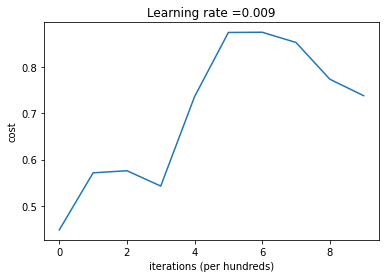

Y.shape (10, 10000)
Y_hat.shape (10, 10000)
0.0


In [ ]:
layers_dims = (784, 20, 7, 5, 10)
learning_rate = 0.009
num_iterations = 10
batch_size = 10
params = L_layer_model(X_train, Y_train, layers_dims, learning_rate, num_iterations, batch_size, X_val, Y_val, False)
accuracy = Predict(X_test, Y_test, params)
print(accuracy)